In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pickle

import sys
sys.path.append('../../')
from Pulses import STA_pulses
from QEnvs.QEnvWave import QEnvWave
from Plots import plot_best_episode, plot_populations, plot_pulses

2023-06-16 19:08:51.391290: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-16 19:08:51.935482: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def dummy_cost_function(env):
    return 0.0

def calculate_populations(env, pulse):
    times = env.times
    populations = []
    for state in env.run_qevolution(pulse):
        populations.append(np.abs(state) ** 2)
    return times, np.array(populations)

Max pulses:  1.0
Max intermediate population:  0.999999993511651
Final population:  0.9949906197972457


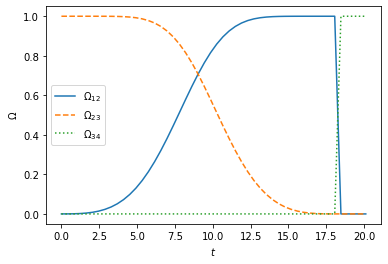

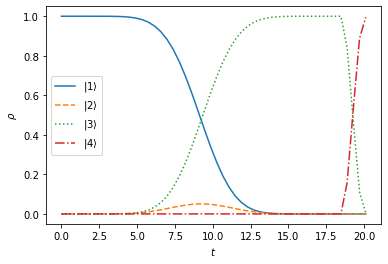

In [3]:
num_steps = 50
time_max_3 = 18.22
time_max_seq = 1.89
time_max = time_max_3 + time_max_seq

num_steps_sta = int(num_steps * time_max_3 / time_max)
num_qubits = 4
omega_max = 1.

pulses = STA_pulses(num_qubits - 1, time_max_3, num_steps_sta, omega_max)
pulses = np.vstack([pulses.T, np.zeros(pulses.shape[0])]).T
for i in range(num_steps - pulses.shape[0]):
    sequential = np.zeros(pulses.shape[1])
    sequential[-1] = omega_max
    pulses = np.vstack([pulses, sequential])

env = QEnvWave(num_qubits=num_qubits,
                time_max=time_max,
                num_steps=num_steps - 1,
                cost_function=dummy_cost_function)
times, populations = calculate_populations(env, pulses)
populations = populations.reshape((num_steps, num_qubits))
pulses_sta_seq = pulses

plot_pulses(times, pulses)
plot_populations(times, populations)
print("Max pulses: ", np.max(pulses))
print("Max intermediate population: ", np.max(populations.T[1:-1]))
print("Final population: ", populations[-1][-1])

Max pulses:  2.495318840441098
Max intermediate population:  0.050547251519012494
Final population:  0.9941471852749767


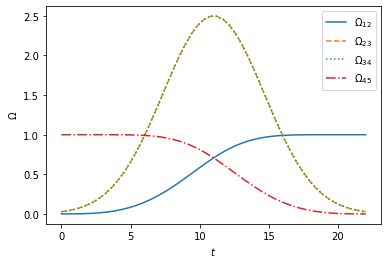

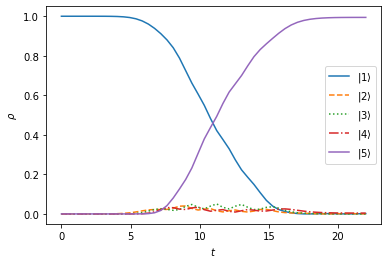

In [4]:
num_steps = 50
time_max = 22
num_qubits = 5
alpha_max = 1/np.sqrt(2)
omega_max=2.5/10

pulses = STA_pulses(num_qubits, time_max, num_steps, alpha_max, omega_max, sigma=time_max/6)

env = QEnvWave(num_qubits=num_qubits,
                time_max=time_max,
                num_steps=num_steps - 1,
                cost_function=dummy_cost_function)
times, populations = calculate_populations(env, pulses)
populations = populations.reshape((num_steps, num_qubits))
pulses_sta_straddling = pulses

plot_pulses(times, pulses)
plot_populations(times, populations)
print("Max pulses: ", np.max(pulses))
print("Max intermediate population: ", np.max(populations.T[1:-1]))
print("Final population: ", populations[-1][-1])

In [5]:
episode_sta_seq = np.load("Data/4_5/4/eval_best_episode.npy", allow_pickle=True)
episode_sta_seq[2] = pulses_sta_seq.T

episode_4_me = np.load("Data/4_5/4/eval_best_episode.npy", allow_pickle=True)

episode_sta_straddling = np.load("Data/4_5/5/eval_best_episode.npy", allow_pickle=True)
episode_sta_straddling[2] = pulses_sta_straddling.T

epìsode_5_me = np.load("Data/4_5/5/eval_best_episode.npy", allow_pickle=True)

episodes = [episode_sta_seq, episode_4_me, episode_sta_straddling, epìsode_5_me]
episodes_me = [False, True, False, True]
episode_qubits = [4, 4, 5, 5]
episodes_names = ["Pure - STA \& Sequential", "Mixed - P", "Pure - STA \& Straddling", "Mixed - P"]

In [6]:
def dummy_cost_function(env):
    return 0.0

def calculate_populations(env, pulse):
    times = env.times
    populations = []
    for state in env.run_qevolution(pulse):
        populations.append(np.abs(state) ** 2)
    return times, np.array(populations)

In [7]:
def simulate_episode(episode, num_qubits, me=False):
    num_steps = episode[1].shape[0] - 1
    time_max = episode[1][-1]
    if me:
        pulses = episode[2][:-1].T
    else:
        pulses = episode[2].T

    env = QEnvWave(num_qubits=num_qubits,
                   time_max=time_max,
                   num_steps=num_steps - 1,
                   cost_function=dummy_cost_function)
    times, populations = calculate_populations(env, pulses)
    return times, pulses, populations.reshape((num_steps, num_qubits))

In [8]:
times = []
pulses = []
populations = []
for episode, qubits, me in zip(episodes, episode_qubits, episodes_me):
    t, p, pop = simulate_episode(episode, qubits, me)
    times.append(t)
    pulses.append(p)
    populations.append(pop)

In [9]:
# Save
results = [episodes_names, times, pulses, populations]
with open("Data/4_5_states_comparison.pkl", "wb") as file:
    pickle.dump(results, file)